# GCM Bias correction

Notebook environment to Perform Delta method bias correction

1) There a several methods of bias correction most popularly Delta method and Quantile Quantile mapping
2) In this notebook we will do the simpler delta method by finding the difference between the 21year average 1993-2014 of ERA5 as the ground truth and the 8GCM's Hindcasted results over the same period
3) This average will then be saved and used to correct the Annual max results prior to performing the EVA

In [119]:
import pystac_client
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px
import os
import math
import glob
import pathlib

from tqdm import tqdm
from scipy.stats import genextreme


<xarray.Dataset>
Dimensions:    (latitude: 361, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
Data variables:
    swh        (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan

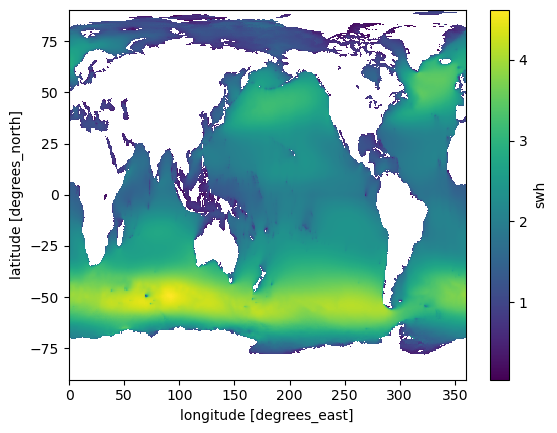

In [143]:
ERA5_Mean=xr.open_zarr(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5_Mean_1993-2014.zarr")
ERA5_Mean=ERA5_Mean.compute()
ERA5_Mean["swh"].plot()
ERA5_Mean

In [6]:
Hindcast_mean_dir=r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\02_Future\Extreme_wave_height\HindCast_mean\Mean"

# Get a list of all netCDF files in the specified directory
files = sorted(glob.glob(os.path.join(Hindcast_mean_dir,  "*.zarr")))

datasets=[]
for file_name in files:
        # Open datasets using lazily in Chunks
        datasets.append(xr.open_zarr(file_name, chunks={'time':  1}))
datasets

[<xarray.Dataset>
 Dimensions:        (latitude: 361, longitude: 720)
 Coordinates:
   * latitude       (latitude) float32 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
   * longitude      (longitude) float32 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
 Data variables:
     hs_ACCESS_CM2  (latitude, longitude) float32 dask.array<chunksize=(361, 720), meta=np.ndarray>,
 <xarray.Dataset>
 Dimensions:           (latitude: 361, longitude: 720)
 Coordinates:
   * latitude          (latitude) float32 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
   * longitude         (longitude) float32 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
 Data variables:
     hs_AWI_CM_1_1_MR  (latitude, longitude) float32 dask.array<chunksize=(361, 720), meta=np.ndarray>,
 <xarray.Dataset>
 Dimensions:          (latitude: 361, longitude: 720)
 Coordinates:
   * latitude         (latitude) float32 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
   * longitude        (longitude) float32 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
 Data variables:
     hs_C

<xarray.Dataset>
Dimensions:        (latitude: 361, longitude: 720)
Coordinates:
  * latitude       (latitude) float32 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * longitude      (longitude) float32 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
Data variables:
    hs_ACCESS_CM2  (latitude, longitude) float32 dask.array<chunksize=(361, 720), meta=np.ndarray>

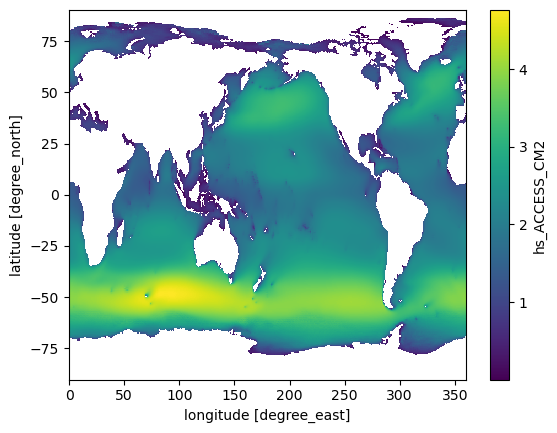

In [81]:
datasets[0]["hs_ACCESS_CM2"].plot()
datasets[0]

Due to the reversing of the latitude value in the GCM We will just invert the ERA5 latitude and corresponding variable data

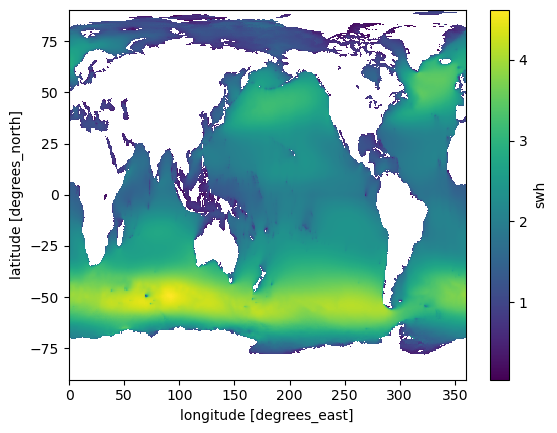

In [41]:
#Invert ERA5 lat and variable

ERA5_Mean_flip=ERA5_Mean.copy()
ERA5_Mean_flip['swh'] = ERA5_Mean_flip['swh'][::-1]
ERA5_Mean_flip['latitude'] = ERA5_Mean_flip['latitude'][::-1]
ERA5_Mean_flip["swh"].plot()

Text(0.5, 1.0, 'Delta Method (Δ) \n Difference between ERA5 21yr mean and ACCESS_CM2 21 year mean')

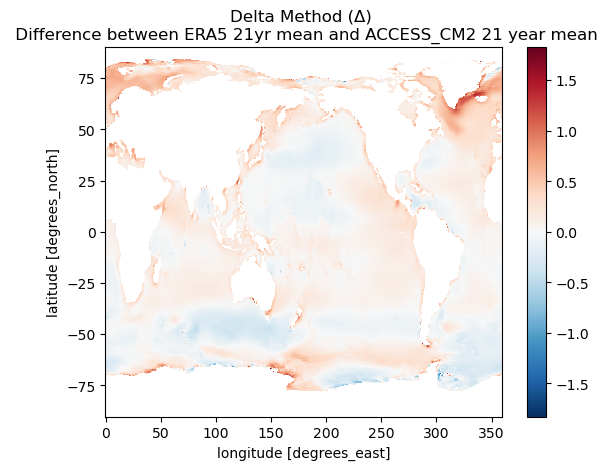

In [45]:
# Visualize the differences
(ERA5_Mean_flip["swh"]-datasets[0]["hs_ACCESS_CM2"]).plot()
plt.title("Delta Method (Δ) \n Difference between ERA5 21yr mean and ACCESS_CM2 21 year mean")

In [47]:
#Creat a bias correction storage
Bias_correction=datasets[0].copy()
Bias_correction=Bias_correction.drop_vars("hs_ACCESS_CM2")
Bias_correction



<xarray.Dataset>
Dimensions:    (latitude: 361, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
Data variables:
    *empty*

In [57]:
variables_list = list(datasets[0].data_vars.keys())[0].replace("hs","Δ_hs")
variables_list

'Δ_hs_ACCESS_CM2'

In [84]:
for dataset in datasets:
    orig_var_name=list(dataset.data_vars.keys())[0]
    new_var_name=orig_var_name.replace("hs","Δ_hs")
    Bias_correction[new_var_name]=ERA5_Mean_flip["swh"]-dataset[orig_var_name]
Bias_correction=Bias_correction.compute()
Bias_correction


<xarray.Dataset>
Dimensions:             (latitude: 361, longitude: 720)
Coordinates:
  * latitude            (latitude) float32 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
  * longitude           (longitude) float32 0.0 0.5 1.0 ... 358.5 359.0 359.5
Data variables:
    Δ_hs_ACCESS_CM2     (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_AWI_CM_1_1_MR  (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_CMCC_CM2_SR5   (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_EC_EARTH3      (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_IPSL_CM6A_LR   (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_KIOST_ESM      (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_MPI_ESM1_2_LR  (latitude, longitude) float32 nan nan nan ... nan nan
    Δ_hs_MRI_ESM2_0     (latitude, longitude) float32 nan nan nan ... nan nan

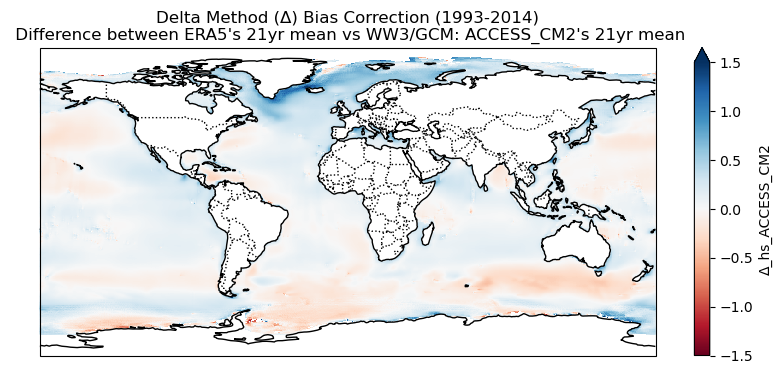

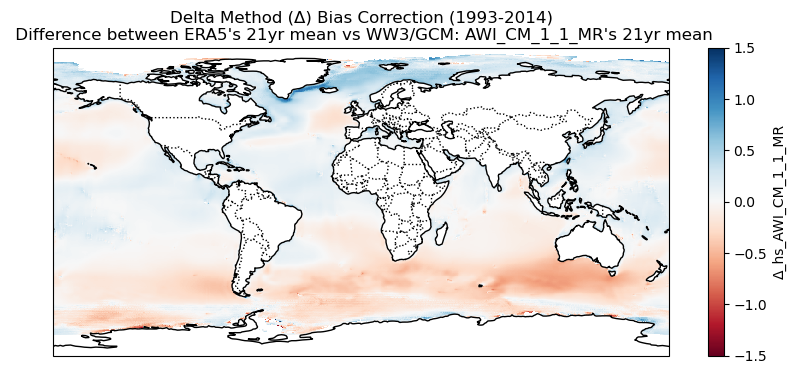

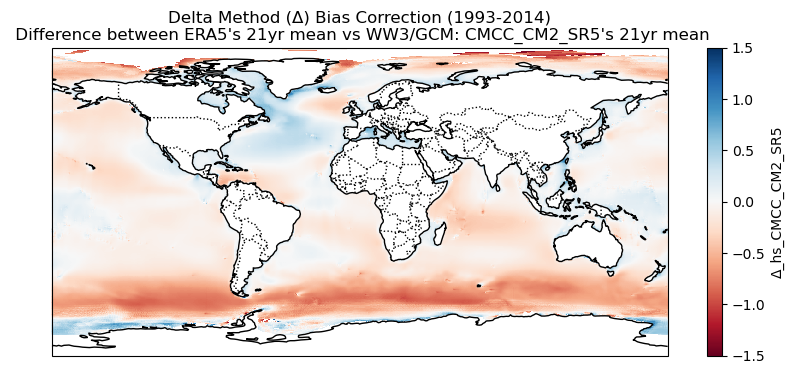

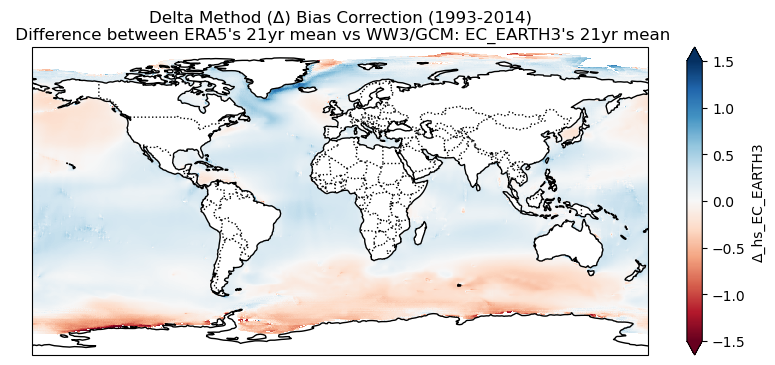

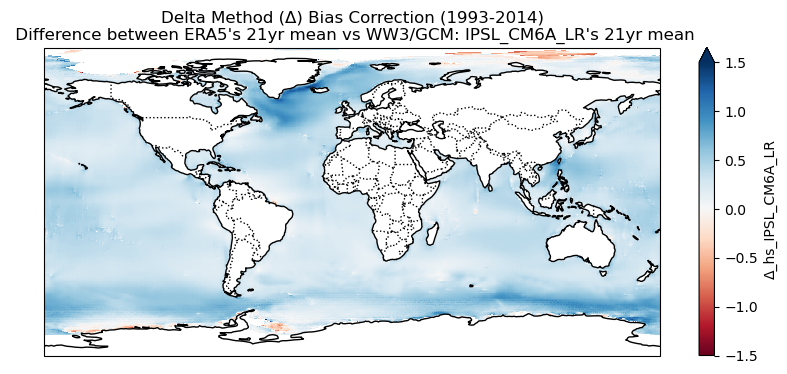

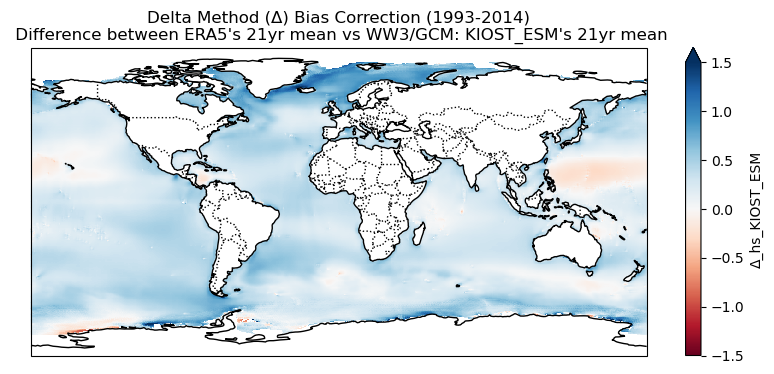

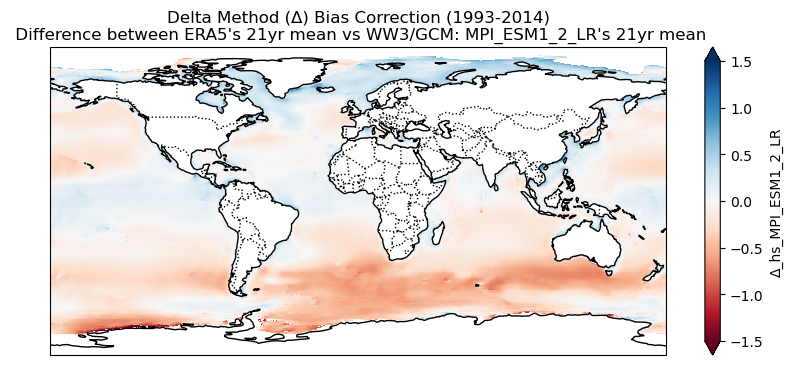

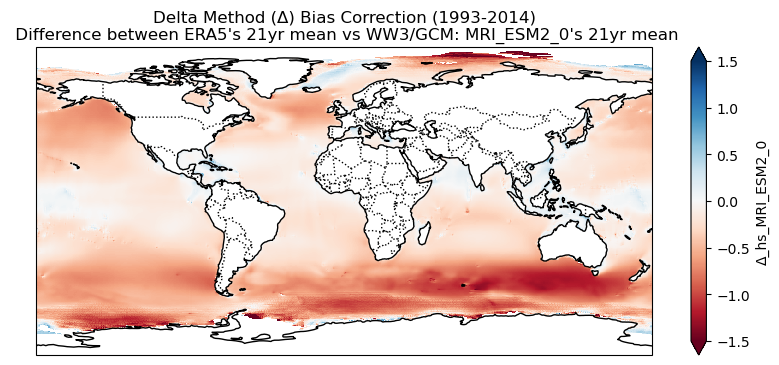

In [87]:
for var in list(Bias_correction.data_vars.keys()):
    # Plot data variable
    plt.figure(figsize=(10, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    Bias_correction[var].plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1.5, vmax=1.5,cmap='RdBu')  # Set similar colour bars
    
    # Add countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.add_feature(cartopy.feature.COASTLINE)

    
    # Title
    plt.title(f"Delta Method (Δ) Bias Correction (1993-2014)\n Difference between ERA5's 21yr mean vs WW3/GCM: {var.replace('Δ_hs_','')}'s 21yr mean")
    
    # Show plot
    plt.show()

In [104]:
#Save the bias correction
Bias_correction.to_zarr(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\STEP 3- Bias Correcting Annual Mean\Delta_Bias_correction.zarr")


In [130]:
Bias_correction=xr.open_zarr(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\STEP 3- Bias Correcting Annual Mean\Delta_Bias_correction.zarr")
Bias_correction

<xarray.Dataset>
Dimensions:             (latitude: 361, longitude: 720)
Coordinates:
  * latitude            (latitude) float32 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
  * longitude           (longitude) float32 0.0 0.5 1.0 ... 358.5 359.0 359.5
Data variables:
    Δ_hs_ACCESS_CM2     (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    Δ_hs_AWI_CM_1_1_MR  (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    Δ_hs_CMCC_CM2_SR5   (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    Δ_hs_EC_EARTH3      (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    Δ_hs_IPSL_CM6A_LR   (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    Δ_hs_KIOST_ESM      (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    Δ_hs_MPI_ESM1_2_LR  (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>
    Δ_hs_MRI_ESM2_0     (latitude, longitude) float32 dask.array<chunksize=(181, 360), meta=np.ndarray>

Bias Correct the 2 phase 1 GCMs first EC EARTH and ACCESS-CM2

In [131]:
gcm_EC_EARTH3=xr.open_zarr(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\02_Future\Extreme_wave_height\Projection_2040-2100_Phase1\EC-EARTH3\Annual_max_GCM_2040-2100\EVA_GCM_2040_2100_Ocean_Points.zarr")
gcm_EC_EARTH3

<xarray.Dataset>
Dimensions:    (time: 61, latitude: 361, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * time       (time) datetime64[ns] 2040-12-31 2041-12-31 ... 2100-12-31
Data variables:
    hs_1_26    (time, latitude, longitude) float32 dask.array<chunksize=(1, 361, 720), meta=np.ndarray>
    hs_5_85    (time, latitude, longitude) float32 dask.array<chunksize=(1, 361, 720), meta=np.ndarray>
Attributes: (12/36)
    AUTHOR:                        Commonwealth Scientific and Industrial Res...
    CITATION:                      CSIRO. (Year).  2040-2100 CMIP6 EC-EARTH S...
    COMMENT:                       The dataset includes significant wave heig...
    CRS:                           EPSG:4326
    Conventions:                   CF-1.8
    DESCRIPTION:                   The dataset contains projections of signif...
    ...                            ...
    northernmost_latitude:         90.
    product_name:                  ww3.204001_hs.nc
    southernmost_latitude:         -90.
    start_date:                    2040-01-01 00:00:00
    stop_date:                     2040-01-31 21:00:00
    westernmost_longitude:         0.

Mid_Century 2040-2070

In [132]:
GCM_all=["EC_EARTH3","ACCESS_CM2"]

In [133]:
all_century=[]
for GCM in GCM_all:
    if GCM=="EC_EARTH3":
        ds_p1_all=xr.open_zarr(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\02_Future\Extreme_wave_height\Projection_2040-2100_Phase1\EC-EARTH3\Annual_max_GCM_2040-2100\EVA_GCM_2040_2100_Ocean_Points.zarr")
        ds_p1_all = ds_p1_all.rename({ 'hs_1_26': 'hs_1_26_EC_EARTH3' })
        ds_p1_all = ds_p1_all.rename({ 'hs_5_85': 'hs_5_85_EC_EARTH3' })
    if GCM=="ACCESS_CM2":
        ds_p1_all=xr.open_zarr(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\02_Future\Extreme_wave_height\Projection_2040-2100_Phase1\ACCESS-CM2\EVA_GCM_ACCESS-CM2-2040_2100_Ocean_Points.zarr")
        ds_p1_all = ds_p1_all.rename({ 'hs_1_26': 'hs_1_26_ACCESS_CM2' })
        ds_p1_all = ds_p1_all.rename({ 'hs_5_85': 'hs_5_85_ACCESS_CM2' })

    # ds_p1_all=ds_p1_all.sel(time=slice("2040-12-31","2071-12-31")) slice later

    ds_p1_all_BC=ds_p1_all.copy()
    for var in list(ds_p1_all_BC.data_vars.keys()):
        ds_p1_all_BC[var]=ds_p1_all_BC[var]+Bias_correction["Δ_hs_"+GCM]
    all_century.append(ds_p1_all_BC)
all_century[0]


<xarray.Dataset>
Dimensions:            (time: 61, latitude: 361, longitude: 720)
Coordinates:
  * latitude           (latitude) float32 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
  * longitude          (longitude) float32 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
  * time               (time) datetime64[ns] 2040-12-31 ... 2100-12-31
Data variables:
    hs_1_26_EC_EARTH3  (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_5_85_EC_EARTH3  (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
Attributes: (12/36)
    AUTHOR:                        Commonwealth Scientific and Industrial Res...
    CITATION:                      CSIRO. (Year).  2040-2100 CMIP6 EC-EARTH S...
    COMMENT:                       The dataset includes significant wave heig...
    CRS:                           EPSG:4326
    Conventions:                   CF-1.8
    DESCRIPTION:                   The dataset contains projections of signif...
    ...                            ...
    northernmost_latitude:         90.
    product_name:                  ww3.204001_hs.nc
    southernmost_latitude:         -90.
    start_date:                    2040-01-01 00:00:00
    stop_date:                     2040-01-31 21:00:00
    westernmost_longitude:         0.

In [134]:
for idx,GCM_ds in enumerate(all_century):
    if idx==0:
        comb_full_century=GCM_ds
    else:
        for var in list(GCM_ds.data_vars.keys()):
            comb_full_century[var]=GCM_ds[var]
comb_mid_century_p1=comb_full_century.sel(time=slice("2040-12-31","2071-12-31"))
comb_end_century_p1=comb_full_century.sel(time=slice("2071-12-31",None))
comb_mid_century_p1

<xarray.Dataset>
Dimensions:             (time: 32, latitude: 361, longitude: 720)
Coordinates:
  * latitude            (latitude) float32 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
  * longitude           (longitude) float32 0.0 0.5 1.0 ... 358.5 359.0 359.5
  * time                (time) datetime64[ns] 2040-12-31 ... 2071-12-31
Data variables:
    hs_1_26_EC_EARTH3   (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_5_85_EC_EARTH3   (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_1_26_ACCESS_CM2  (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_5_85_ACCESS_CM2  (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
Attributes: (12/36)
    AUTHOR:                        Commonwealth Scientific and Industrial Res...
    CITATION:                      CSIRO. (Year).  2040-2100 CMIP6 EC-EARTH S...
    COMMENT:                       The dataset includes significant wave heig...
    CRS:                           EPSG:4326
    Conventions:                   CF-1.8
    DESCRIPTION:                   The dataset contains projections of signif...
    ...                            ...
    northernmost_latitude:         90.
    product_name:                  ww3.204001_hs.nc
    southernmost_latitude:         -90.
    start_date:                    2040-01-01 00:00:00
    stop_date:                     2040-01-31 21:00:00
    westernmost_longitude:         0.

In [135]:
#Save the Mid Century data
comb_mid_century_p1.to_zarr(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\STEP 3- Bias Correcting Annual Mean\Mid_Century_Ann_Max_Corrected_GCM")

In [136]:
comb_end_century_p1

<xarray.Dataset>
Dimensions:             (time: 30, latitude: 361, longitude: 720)
Coordinates:
  * latitude            (latitude) float32 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
  * longitude           (longitude) float32 0.0 0.5 1.0 ... 358.5 359.0 359.5
  * time                (time) datetime64[ns] 2071-12-31 ... 2100-12-31
Data variables:
    hs_1_26_EC_EARTH3   (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_5_85_EC_EARTH3   (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_1_26_ACCESS_CM2  (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_5_85_ACCESS_CM2  (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
Attributes: (12/36)
    AUTHOR:                        Commonwealth Scientific and Industrial Res...
    CITATION:                      CSIRO. (Year).  2040-2100 CMIP6 EC-EARTH S...
    COMMENT:                       The dataset includes significant wave heig...
    CRS:                           EPSG:4326
    Conventions:                   CF-1.8
    DESCRIPTION:                   The dataset contains projections of signif...
    ...                            ...
    northernmost_latitude:         90.
    product_name:                  ww3.204001_hs.nc
    southernmost_latitude:         -90.
    start_date:                    2040-01-01 00:00:00
    stop_date:                     2040-01-31 21:00:00
    westernmost_longitude:         0.

In [137]:
GCM_all=["MRI-ESM2-0","MPI-ESM1-2-LR","KIOST-ESM","IPSL-CM6A-LR","CMCC-CM2-SR5","AWI-CM-1-1-MR"]

In [138]:
base_path=pathlib.Path(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\02_Future\Extreme_wave_height\Projection_2070-2100-Phase2\Ann_Max")

end_century=[]
for GCM in GCM_all:
    ds_p2_end=xr.open_zarr(base_path.joinpath(f"{GCM}Ann_max_2070-2100.zarr"))

    ds_p2_end_BC=ds_p2_end.copy()
    for var in list(ds_p2_end_BC.data_vars.keys()):
        ds_p2_end_BC[var]=ds_p2_end_BC[var]+Bias_correction["Δ_hs_"+GCM.replace("-", "_")]
    end_century.append(ds_p2_end_BC)
end_century


[<xarray.Dataset>
 Dimensions:             (time: 30, latitude: 361, longitude: 720)
 Coordinates:
   * latitude            (latitude) float32 -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
   * longitude           (longitude) float32 0.0 0.5 1.0 ... 358.5 359.0 359.5
   * time                (time) datetime64[ns] 2071-12-31 ... 2100-12-31
 Data variables:
     hs_1_26_MRI_ESM2_0  (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
     hs_5_85_MRI_ESM2_0  (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
 Attributes: (12/36)
     AUTHOR:                        Commonwealth Scientific and Industrial Res...
     CITATION:                      CSIRO. (Year).  2071-2100 CMIP6 MRI-ESM2-0...
     COMMENT:                       The dataset includes significant wave heig...
     CRS:                           EPSG:4326
     Conventions:                   CF-1.8
     DESCRIPTION:                   The dataset contains projection

In [139]:
comb_full_centuryp1_p2=comb_end_century_p1.copy()
for idx,GCM_ds in enumerate(end_century):
        for var in list(GCM_ds.data_vars.keys()):
            comb_full_centuryp1_p2[var]=GCM_ds[var]
comb_full_centuryp1_p2

<xarray.Dataset>
Dimensions:                (time: 30, latitude: 361, longitude: 720)
Coordinates:
  * latitude               (latitude) float32 -90.0 -89.5 -89.0 ... 89.5 90.0
  * longitude              (longitude) float32 0.0 0.5 1.0 ... 358.5 359.0 359.5
  * time                   (time) datetime64[ns] 2071-12-31 ... 2100-12-31
Data variables: (12/16)
    hs_1_26_EC_EARTH3      (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_5_85_EC_EARTH3      (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_1_26_ACCESS_CM2     (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_5_85_ACCESS_CM2     (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_1_26_MRI_ESM2_0     (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_5_85_MRI_ESM2_0     (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    ...                     ...
    hs_1_26_IPSL_CM6A_LR   (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_5_85_IPSL_CM6A_LR   (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_1_26_CMCC_CM2_SR5   (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_5_85_CMCC_CM2_SR5   (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_1_26_AWI_CM_1_1_MR  (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
    hs_5_85_AWI_CM_1_1_MR  (time, latitude, longitude) float32 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
Attributes: (12/36)
    AUTHOR:                        Commonwealth Scientific and Industrial Res...
    CITATION:                      CSIRO. (Year).  2040-2100 CMIP6 EC-EARTH S...
    COMMENT:                       The dataset includes significant wave heig...
    CRS:                           EPSG:4326
    Conventions:                   CF-1.8
    DESCRIPTION:                   The dataset contains projections of signif...
    ...                            ...
    northernmost_latitude:         90.
    product_name:                  ww3.204001_hs.nc
    southernmost_latitude:         -90.
    start_date:                    2040-01-01 00:00:00
    stop_date:                     2040-01-31 21:00:00
    westernmost_longitude:         0.

In [140]:
#Save the End Century data
comb_full_centuryp1_p2.to_zarr(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\STEP 3- Bias Correcting Annual Mean\End_Century_Ann_Max_Corrected_GCM.zarr")

In [141]:
comb_full_centuryp1_p2=xr.open_zarr(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\STEP 3- Bias Correcting Annual Mean\End_Century_Ann_Max_Corrected_GCM.zarr")
comb_full_centuryp1_p2

FileNotFoundError: No such file or directory: 'P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\01_Hazards\01_Present\Extreme_wave_height\ERA5 Nearshore Mapping\STEP 3- Bias Correcting Annual Mean\End_Century_Ann_Max_Corrected_GCM.zarr'